In [516]:
import math
import torch
import gpytorch
import tensorflow as tf
from matplotlib import pyplot as plt

from torch import optim
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.likelihoods import BernoulliLikelihood
from gpytorch.means import ConstantMean
from gpytorch.priors import SmoothedBoxPrior
from gpytorch.distributions import MultivariateNormal
from gpytorch.models import ApproximateGP
from gpytorch.variational import AdditiveGridInterpolationVariationalStrategy, CholeskyVariationalDistribution
%matplotlib inline
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [517]:
train_x = torch.linspace(0, 1, 10)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.cos(train_x * (2 * math.pi))
training_iter=10
likelihood = gpytorch.likelihoods.GaussianLikelihood()

In [518]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.CosineKernel())
#        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    
class TestKISSGPAdditiveClassification(unittest.TestCase):

    def __init__(self):
        self.model: Optional[GPClassificationModel] = None
        self.criterion: Optional[torch.nn.MSELoss] = None
        self.optimizer: Optional[torch.optim.SGD] = None
        
        
    def reset(self, train_x, train_y, likelihood):
        self.model = ExactGPModel(train_x, train_y, likelihood)
        self.mll = gpytorch.mlls.VariationalELBO(likelihood, self.model, num_data=len(train_y))
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.15)
        
    def test_kissgp_classification_error(self):
        # Find optimal model hyperparameters
#        likelihood = gpytorch.likelihoods.GaussianLikelihood()
      #  self.model = ExactGPModel(train_x, train_y, likelihood)
        self.model.train()
        likelihood.train()
        self.mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, self.model)
        
        for i in range(training_iter):
            self.optimizer.zero_grad()
            output = self.model(train_x)
            loss = -mll(output, train_y)
            loss.backward()
            print('Iter %d/%d - Loss: %.3f   noise: %.3f' % (
                i + 1, training_iter, loss.item(),
                self.model.likelihood.noise.item()
            ))
            self.optimizer.step()
        
        test_preds = self.model(train_x).mean.ge(0.5).float()
        mean_abs_error = torch.mean(torch.abs(train_y - test_preds) / 2)
        print(mean_abs_error.item())
        

        

In [519]:
linrun = TestKISSGPAdditiveClassification()

In [520]:
linrun.reset(train_x, train_y, likelihood)
linrun.test_kissgp_classification_error()

Iter 1/10 - Loss: 1.412   noise: 0.693
Iter 2/10 - Loss: 1.412   noise: 0.693
Iter 3/10 - Loss: 1.412   noise: 0.693
Iter 4/10 - Loss: 1.412   noise: 0.693
Iter 5/10 - Loss: 1.412   noise: 0.693
Iter 6/10 - Loss: 1.412   noise: 0.693
Iter 7/10 - Loss: 1.412   noise: 0.693
Iter 8/10 - Loss: 1.412   noise: 0.693
Iter 9/10 - Loss: 1.412   noise: 0.693
Iter 10/10 - Loss: 1.412   noise: 0.693
0.3379385769367218


In [521]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 20)
    observed_pred = likelihood(model(test_x))
    observed_pred
    
    

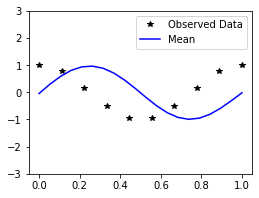

In [522]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
 #   ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [523]:
print(observed_pred)

MultivariateNormal(loc: torch.Size([20]))


In [510]:
observed_pred.loc

tensor([-0.0448,  0.2906,  0.5835,  0.8052,  0.9348,  0.9608,  0.8815,  0.7053,
         0.4500,  0.1422, -0.1852, -0.4952, -0.7520, -0.9251, -0.9944, -0.9535,
        -0.8103, -0.5858, -0.3108, -0.0200])